In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Competition and Data
https://www.kaggle.com/competitions/nlp-getting-started/overview

Objective: <br>
Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t with a dataset of 10,000 tweets that were hand classified.

# Setup

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn as sk
import tensorflow as tf

In [3]:
import os
import random
    
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seeds(42)

In [4]:
train_path = "/kaggle/input/nlp-getting-started/train.csv"
train_data = pd.read_csv(train_path)
test_path = "/kaggle/input/nlp-getting-started/test.csv"
test_data = pd.read_csv(test_path)

In [5]:
# test_data doesn't contain labels, so it cannot actually be used as the test set.
# It can only be used for the submission predictions.
pred_data = test_data
# test_data.tail()
test_data.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

# Data Overview

In [6]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


# Exploratory Data Analysis
Additional EDA for the keyword and location columns would he helpful.

Could add:
* N-gram
* Common stopwords
* Common punctuations, e.g. exclamation marks (!) might be more prevalent in disaster tweets.
* Word clouds


### Vocabulary Size/Number of unique words
This does not account for punctuation.

In [9]:
def count_unique_words(series):
    all_words = ' '.join(series.tolist())
    unique_words = set(all_words.split())
    return len(unique_words)

word_count = count_unique_words(train_data['text'])
word_count

31924

### Class distribution

The number of disaster tweets is significantly lower. When not addressed, this can have a negative impact on the model's results. The training data can be balanced by utilizing oversampling, undersampling, or a comibination of both.

<AxesSubplot:>

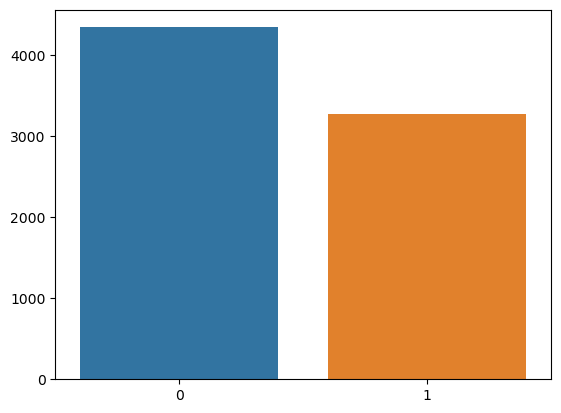

In [10]:
# Class distribution
class_counts = train_data['target'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)

### Tweet Keyword

There is no meaningful difference in the percentage of tweets with no keyword for each class.

In [11]:
# Percentage of null and non-null keyword values per target.
keyword_null = train_data.groupby('target').apply(lambda x: pd.Series({
    'Null %': (x['keyword'].isnull().sum() / len(x['keyword'])) * 100,
    'Non-null %': (x['keyword'].notnull().sum() / len(x['keyword'])) * 100
})).reset_index() # reset_index? Necessary?
keyword_null

,target,Null %,Non-null %
0,0,0.437586,99.562414
1,1,1.284011,98.715989


### Tweet Location

There is no meaningful difference in the percenage of tweets with no location for each class.

In [12]:
# Percentage of null and non-null location values per target.
location_null = train_data.groupby('target').apply(lambda df: pd.Series({
    'Null %': (df['location'].isnull().sum() / len(df['location'])) * 100,
    'Non-null %': (df['location'].notnull().sum() / len(df['location'])) * 100
})).reset_index() # reset_index? Necessary?
location_null

,target,Null %,Non-null %
0,0,33.578996,66.421004
1,1,32.864567,67.135433


### Tweet Length: Characters

Both the mean and the median of the character length of the disaster tweets are considerable higher that those of the non-disaster tweets, this can be used in the feature engineering step to contruct a new num_of_characters feature.

In [13]:
# Mean and median tweet character length per target.
tweet_length = train_data.groupby('target').apply(lambda df: pd.Series({
    'Mean': df['text'].str.len().mean(),
    'Median': df['text'].str.len().median()})).reset_index() # reset_index?
tweet_length

,target,Mean,Median
0,0,95.706817,101.0
1,1,108.113421,115.0


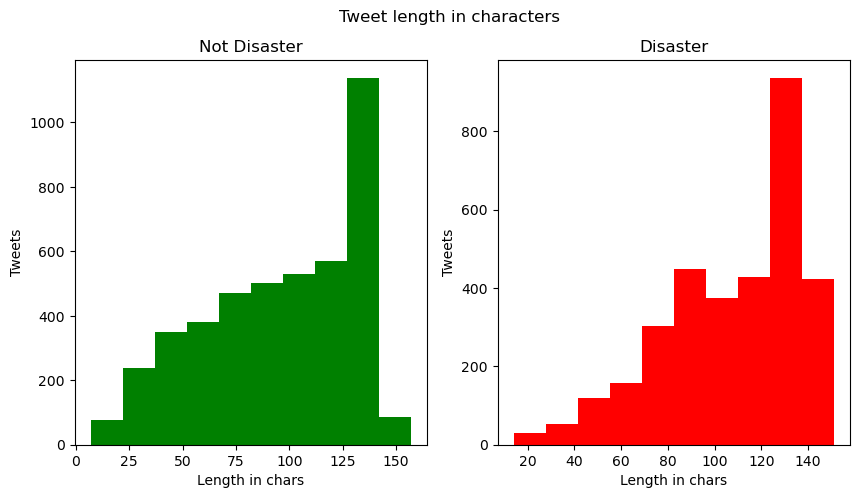

In [14]:
# Tweet character length
chars0 = train_data.loc[train_data['target']==0]['text'].str.len()
chars1 = train_data.loc[train_data['target']==1]['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Tweet length in characters")

ax1.hist(chars0, color='green')
ax1.set_title("Not Disaster")
ax1.set_ylabel("Tweets")
ax1.set_xlabel("Length in chars")

ax2.hist(chars1, color='red')
ax2.set_title("Disaster")
ax2.set_ylabel("Tweets")
ax2.set_xlabel("Length in chars")

plt.show()

### Tweet Length: Words

There is no significant difference in the number of words per tweet.

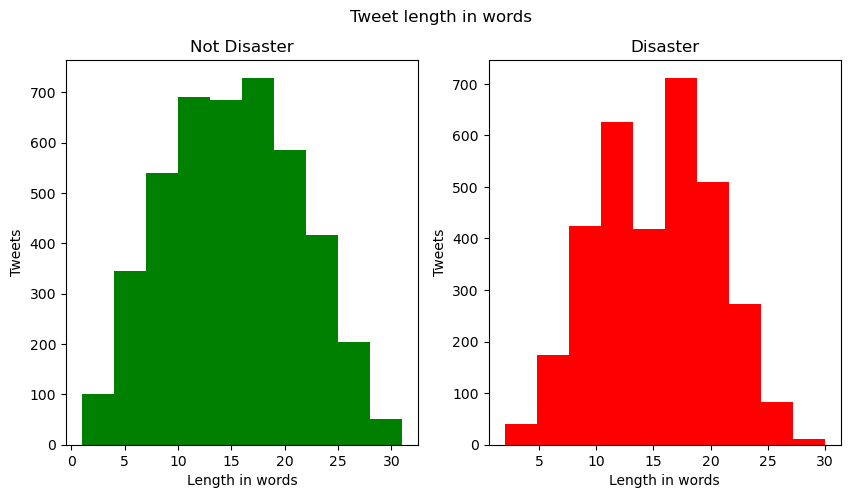

In [15]:
# Tweet word length
words0 = train_data.loc[train_data['target']==0]['text'].str.split().map(len)
words1 = train_data.loc[train_data['target']==1]['text'].str.split().map(len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Tweet length in words")

ax1.hist(words0, color='green')
ax1.set_title("Not Disaster")
ax1.set_ylabel("Tweets")
ax1.set_xlabel("Length in words")

ax2.hist(words1, color='red')
ax2.set_title("Disaster")
ax2.set_ylabel("Tweets")
ax2.set_xlabel("Length in words")

plt.show()

In [16]:
# Mean and Median
words0_stats = words0.agg(func=[np.mean, np.median])
words1_stats = words1.agg(func=[np.mean, np.median])
words_stats = pd.DataFrame({'0': words0_stats, '1': words1_stats})
words_stats

,0,1
mean,14.704744,15.167533
median,15.000000,15.000000


### Average Word Length

This is redundant as the character length gives us very similar information, but it confirms the results of the character length step of the analysisas because the mean and median of the number of words per tweet is almost the same.

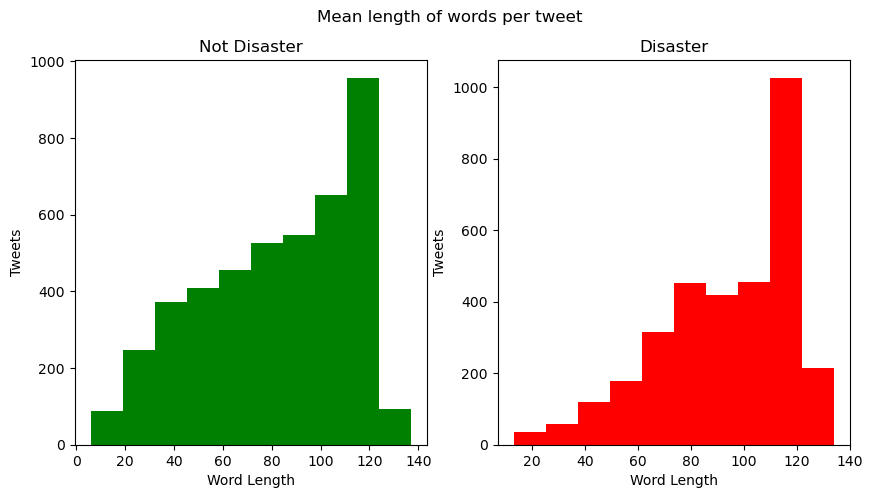

In [17]:
# Word length distributions
word_len0 = train_data.loc[train_data['target']==0]['text'].str.split().map(lambda list_: sum([len(word) for word in list_]))
word_len1 = train_data.loc[train_data['target']==1]['text'].str.split().map(lambda list_: sum([len(word) for word in list_]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Mean length of words per tweet")

ax1.hist(word_len0, color='green')
ax1.set_title("Not Disaster")
ax1.set_ylabel("Tweets")
ax1.set_xlabel("Word Length")

ax2.hist(word_len1, color='red')
ax2.set_title("Disaster")
ax2.set_ylabel("Tweets")
ax2.set_xlabel("Word Length")

plt.show()

In [18]:
# Mean and Median
word_len_stats0 = word_len0.agg(func=[np.mean, np.median])
word_len_stats1 = word_len1.agg(func=[np.mean, np.median])
word_len_stats = pd.DataFrame({'0': word_len_stats0, '1': word_len_stats1})
word_len_stats.T

,mean,median
0,81.857669,87.0
1,93.789361,100.0


### Vocabulary Size

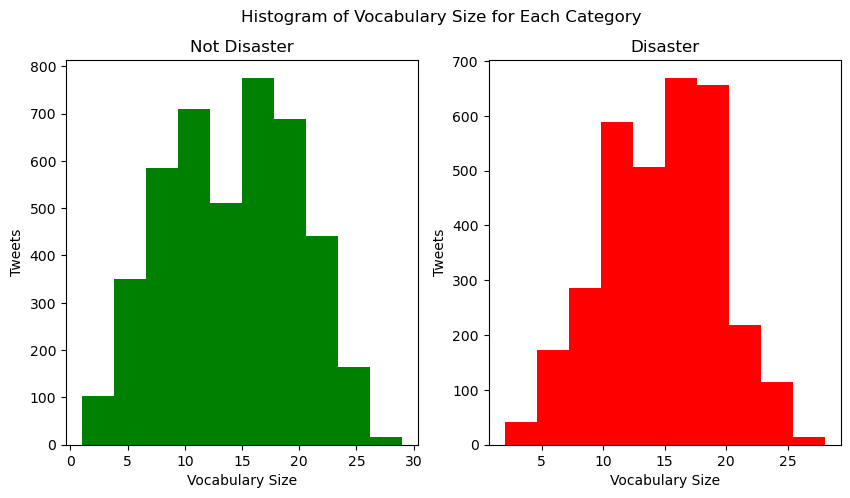

In [19]:
# Class vocabulary size
vocab_size0 = train_data.loc[train_data['target']==0]['text'].apply(lambda x: len(set(x.split())))
vocab_size1 = train_data.loc[train_data['target']==1]['text'].apply(lambda x: len(set(x.split())))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histogram of Vocabulary Size for Each Category")

ax1.hist(vocab_size0, color='green')
ax1.set_title("Not Disaster")
ax1.set_ylabel("Tweets")
ax1.set_xlabel("Vocabulary Size")

ax2.hist(vocab_size1, color='red')
ax2.set_title("Disaster")
ax2.set_ylabel("Tweets")
ax2.set_xlabel("Vocabulary Size")

plt.show()

In [20]:
# Mean and Median
vocab_size0_stats = vocab_size0.agg(func=[np.mean, np.median])
vocab_size1_stats = vocab_size1.agg(func=[np.mean, np.median])
vocab_size_stats = pd.DataFrame({'0': vocab_size0_stats, '1': vocab_size1_stats})
vocab_size_stats

,0,1
mean,14.096499,14.664934
median,14.000000,15.000000


### Common/Frequent Words

In [21]:
# Most common/frequent words per class
import nltk

import pandas as pd
from collections import Counter

def compute_most_common_word(df, column):
    # Concatenate all the text into a single string
    text = ' '.join(df[column].tolist())

    # Remove any punctuation marks and convert to lowercase
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    text = text.lower()

    # Split the text into words and count their occurrences
    words = text.split()
    word_counts = Counter(words)

    # Find the most common word
    most_common_word = word_counts.most_common(1)[0][0]

    return most_common_word

compute_most_common_word(train_data, 'text')

'the'

In [22]:
from collections import Counter

def freq_words(df, column, target_column, target_value, top_words):
    words = [word for list_ in df.loc[df[target_column]==target_value][column].str.split().tolist() for word in list_]
    return pd.DataFrame(Counter(words).most_common(top_words), columns=["Word", "Count"])

In [23]:
freq_words(train_data, 'text', 'target', 0, 20)

,Word,Count
0,the,1524
1,a,1115
2,to,1099
3,I,938
4,and,840
5,of,834
6,in,720
7,you,529
8,is,512
9,for,452


In [24]:
disaster = freq_words(train_data, 'text', 'target', 1, 20)

# Data preprocessing
Could add:
* Stemming
* Lemmatizing
* Spelling Correction

## Data cleaning

### Remove Stopwords

In [25]:
from nltk.corpus import stopwords

# Can alternatively use CountVectorizer's built-in remover.
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    tokens = text.split()
    text = ' '.join([token for token in tokens if token.lower() not in stop_words])
    return text

### Remove URLs

In [26]:
# from bs4 import BeautifulSoup
def remove_urls(text):
#     text = BeautifulSoup(text, "html.parser").get_text()
    url = re.compile(r"https?://\S+|www\.\S+") # 'http\S+'
    return re.sub(url, '', text)

### Remove html tags

In [27]:
import re
def remove_html_tags(text):
    tags = re.compile(r'<.*?>')
    return re.sub(tags, '', text)

### Remove emojis

In [28]:
import emoji
def remove_emojis(text):
    return emoji.replace_emoji(text, replace=' ')

### Remove punctuation

In [29]:
import string
def remove_punctuation(text):
#     text = re.sub(r'[^\w\s]', '', text)
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

## Feature Engineering Ideas

* N-grams
* keyword based
* location based
* imputed, True or False
* Exclamation marks

## Pipeline

In [30]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer#, TfidfVectorizer

def clean_text(text):
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

text_transformer = make_pipeline(FunctionTransformer(lambda x: x.apply(clean_text), validate=False), 
                                 CountVectorizer(lowercase=True))#, TfidfVectorizer(binary=True))

# If the column is enclosed in brackets e.g. ['text'], text_transformer input is a Dataframe.
# If the column is not enclosed in brackets e.g. 'text', text_transformer input is a Series.
# Preprocessor/Column Transformer input must be a dataframe.
preprocessor = make_column_transformer((text_transformer, 'text'))

# Input can be a series
# preprocessor = text_transformer

In [31]:
# Build a pipeline with the model
def model_pipeline(model, preprocessor=preprocessor):
    pipeline = make_pipeline(preprocessor, model) 
    return pipeline

# Train, Test Sets

In [32]:
# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)

# If using a single column with a column transformer
X_train = X_train.to_frame()
X_test = X_test.to_frame()

# Scoring

## Cross-Validation Score

In [33]:
from sklearn.model_selection import cross_val_score

def cv_score(pipeline, X=X_train, y=y_train, cv=5, scoring=['f1', 'roc_auc', 'balanced_accuracy',  'accuracy'][0]):
    scores = 1 * cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    return scores.mean()

## Test Set Evaluation Score

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score

def evaluate(model, metric='accuracy', X=X_test, y=y_test):
    if metric == 'f1':
        return f1_score(y, model.predict(X))
    elif metric == 'roc_auc':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)
    elif metric =='accuracy':
        return model.score(X, y)
    elif metric == 'balanced_accuracy':
        return balanced_accuracy_score(y, model.predict(X))

# Hyperparameter Tuning: Grid Search

In [35]:
from sklearn.model_selection import GridSearchCV#, HalvingGridSearchCV, HalvingRandomSearchCV

# When using GridSearchCV with Pipelines, use model_name__parameter_name

# Add the model name to the parameters
def grid_pipe_params(params, model_name):
    return {model_name + '__' + key: value for key, value in params.items()}

# Remove model_name__ from keys
def remove_model_name(params):
    return {key.split('__')[1]: value for key, value in params.items()}

In [36]:
# Find the optimum model hyperparameters
def grid_search(model, params, X, y):
    search = GridSearchCV(
        model, 
        params, 
        cv=5, 
        scoring= ['f1', 'roc_auc', 'balanced_accuracy',  'accuracy'][-1],
        n_jobs=-1).fit(X, y)
    return search

In [37]:
# Combine the grid search related functions defined above
def grid_search_hyperparameters(params, model, X, y, model_name=False):
    model_name = model_name if model_name else model.steps[-1][0]
    params = grid_pipe_params(params, model_name)
    search = grid_search(model, params, X, y)
    return search

In [38]:
def results(best_model) :
    hp = remove_model_name(best_model.best_params_)
    cross_val = best_model.best_score_
    print(f'Best params:{hp}')
    print(f'Best cross-val score: {cross_val}')
    return hp, cross_val

# Models

## Ridge Classifier

In [39]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier()
ridge = model_pipeline(ridge)
ridge_cv = cv_score(ridge)
ridge_cv

0.71371490338228

In [40]:
ridge.fit(X_train, y_train)
ridge_score = evaluate(ridge)
ridge_score

0.7721602101116218

## Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb = model_pipeline(mnb)
mnb_cv = cv_score(mnb)
mnb_cv

0.7506883377077378

In [42]:
mnb.fit(X_train, y_train)
mnb_score = evaluate(mnb)
mnb_score

0.7905449770190414

In [43]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb = model_pipeline(bnb)
bnb_cv = cv_score(bnb)
bnb_cv

0.723353061363151

In [44]:
bnb.fit(X_train, y_train)
bnb_score = evaluate(bnb)
bnb_score

0.8003939592908733

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr = model_pipeline(lr)
lr_cv = cv_score(lr)
lr_cv

0.7393968864228899

In [46]:
lr.fit(X_train, y_train)
lr_score = evaluate(lr)
lr_score

0.799080761654629

## SVC

In [47]:
from sklearn.svm import SVC
svm = SVC(probability=True)
svm = model_pipeline(svm)
svm_cv = cv_score(svm)
svm_cv

0.7221728629332849

In [48]:
svm.fit(X_train, y_train)
svm_score = evaluate(svm)
svm_score

0.8030203545633617

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt = model_pipeline(dt)
dt_cv = cv_score(dt)
dt_cv

0.6976025537579544

In [50]:
dt.fit(X_train, y_train)
dt_score = evaluate(dt)
dt_score

0.7458962573867367

## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf = model_pipeline(rf)
rf_cv = cv_score(rf)
rf_cv

0.7153273513344284

In [52]:
rf.fit(X_train, y_train)
rf_score = evaluate(rf)
rf_score

0.7793827971109653

## Gradient Boosting

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb = model_pipeline(gb)
gb_cv = cv_score(gb)
gb_cv

0.5995442130866782

In [54]:
gb.fit(X_train, y_train)
gb_score = evaluate(gb)
gb_score

0.7340774786605384

## RNN/LSTM

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# If using a single column with a column transformer
# X_train = X_train.to_frame()
# X_val = X_val.to_frame()
# X_test = X_test.to_frame()

In [56]:
# If X is a Series
X_train = X_train.apply(clean_text)
X_val = X_val.apply(clean_text)
X_test = X_test.apply(clean_text)

# If X is a Dataframe
# X_train = X_train.apply(lambda col: col.apply(clean_text))
# X_val = X_val.apply(lambda col: col.apply(clean_text))
# X_test = X_test.apply(lambda col: col.apply(clean_text))

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, SpatialDropout1D, LayerNormalization
from tensorflow.keras.models import Model

# Parameters
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 50

# Unique word count with cleaned data
unique_words = count_unique_words(X_train)

# Layer definitions
inputs = Input(shape=(1,), dtype=tf.string) # Shape of single string/tweet
vectorizer = tf.keras.layers.TextVectorization(max_tokens=unique_words, output_mode='int')

# Model layers
x = vectorizer(inputs)
x = Embedding(input_dim=unique_words, output_dim=64)(x)
x = SpatialDropout1D(0.3)(x)
x = LSTM(units=128)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

# Model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #'adam'
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          1041856   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 64)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 layer_normalization (LayerN  (None, 128)              256   

In [58]:
X_train = X_train.to_numpy()
vectorizer.adapt(X_train)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model', monitor='val_loss', mode='min', save_best_only=True)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=25, callbacks=callbacks)

loaded_model = tf.keras.models.load_model('best_model')

Epoch 1/25
153/153 [==============================] - 16s 82ms/step - loss: 0.6954 - accuracy: 0.5486 - val_loss: 0.6621 - val_accuracy: 0.5903
Epoch 2/25
153/153 [==============================] - 11s 72ms/step - loss: 0.6254 - accuracy: 0.6544 - val_loss: 0.5279 - val_accuracy: 0.7496
Epoch 3/25
153/153 [==============================] - 12s 76ms/step - loss: 0.4200 - accuracy: 0.8194 - val_loss: 0.4739 - val_accuracy: 0.7874
Epoch 4/25
153/153 [==============================] - 6s 37ms/step - loss: 0.3125 - accuracy: 0.8738 - val_loss: 0.5281 - val_accuracy: 0.7635
Epoch 5/25
153/153 [==============================] - 5s 35ms/step - loss: 0.2398 - accuracy: 0.9050 - val_loss: 0.5596 - val_accuracy: 0.7660
Epoch 6/25
153/153 [==============================] - 5s 34ms/step - loss: 0.1903 - accuracy: 0.9280 - val_loss: 0.6691 - val_accuracy: 0.7332
Epoch 7/25
153/153 [==============================] - 5s 35ms/step - loss: 0.1483 - accuracy: 0.9456 - val_loss: 0.7286 - val_accuracy: 0.7

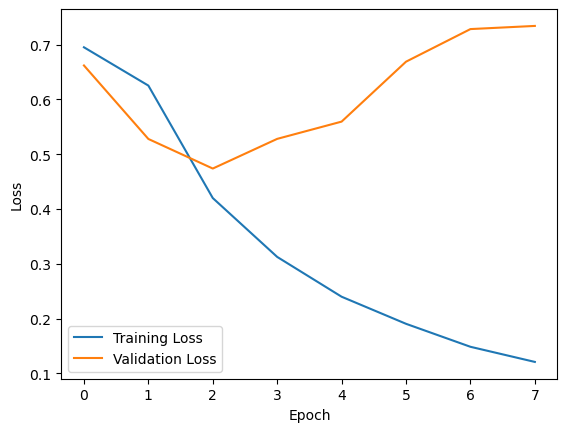

In [59]:
def plot_loss(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(history=history)

In [60]:
rnn_score = loaded_model.evaluate(X_test, y_test)[1]

48/48 [==============================] - 1s 10ms/step - loss: 0.5014 - accuracy: 0.7584


# Model Comparison
Comparing test set scores is what matters when selecting a model. The validation set or cross validation scores are used for hyperparameter tunning.

In [61]:
# Test set accuracy scores
eval_scores = {
    'ridge': ridge_score,
    'mnb': mnb_score,
    'bnb': bnb_score,
    'lr': lr_score,
    'svm': svm_score,
    'dt': dt_score,
    'rf': rf_score,
    'gb': gb_score,
    'rnn': rnn_score
}
eval_scores

{'ridge': 0.7721602101116218,
 'mnb': 0.7905449770190414,
 'bnb': 0.8003939592908733,
 'lr': 0.799080761654629,
 'svm': 0.8030203545633617,
 'dt': 0.7458962573867367,
 'rf': 0.7793827971109653,
 'gb': 0.7340774786605384,
 'rnn': 0.7583716511726379}

Support Vector Classifier has the highest test set evaluation score followed by Bernoulli Naive Bayes. There is a minimal difference between the test set score and the cross validation score, this demonstrates that the model did not overfit the training data set.

In [62]:
max_score = max(eval_scores, key=eval_scores.get)
max_score

'svm'

# Chosen Model's Performance Metrics

Accuracy (accuracy_score) is not a good metric with imbalanced datasets. <br>

Model Evaluation:
* accuracy_score (balanced classes)
* classification_report (imbalanced classes): precision, recall, F1-score 
* confusion_matrix
* roc_auc_score

In [63]:
# For the neural network
# pred_test_prob = loaded_model.predict(X_test)
# pred_test = np.where(pred_test_prob > 0.5, 1, 0)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)

# If using a single column with a column transformer
X_train = X_train.to_frame()
X_test = X_test.to_frame()

pred_test = svm.predict(X_test)
pred_test

array([0, 0, 0, ..., 1, 1, 0])

## Confusion Matrix

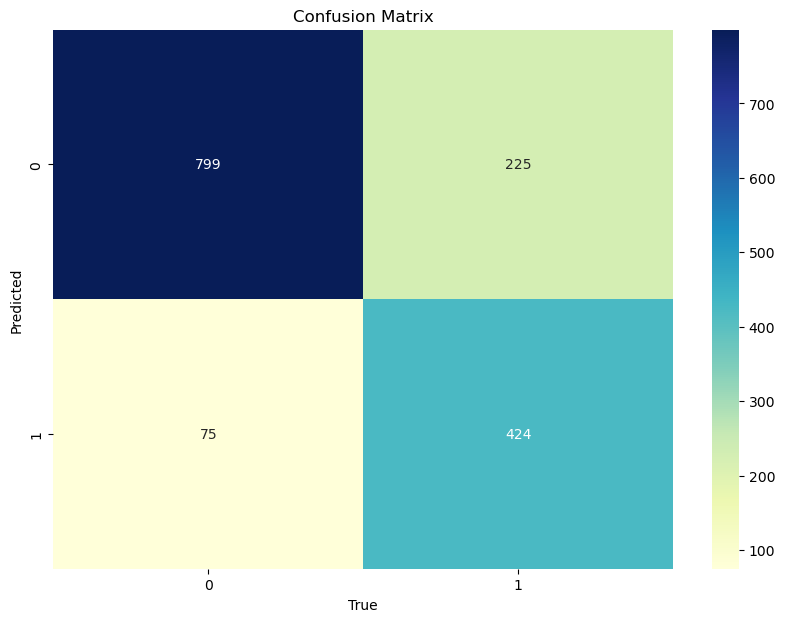

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_test, y_test)

fig = plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d')
ax.set_title("Confusion Matrix")
ax.set_ylabel("Predicted")
ax.set_xlabel("True")
plt.show()

## Precision, Recall, F1-scores

In [66]:
from sklearn.metrics import classification_report

print(classification_report(pred_test, y_test))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1024
           1       0.65      0.85      0.74       499

    accuracy                           0.80      1523
   macro avg       0.78      0.81      0.79      1523
weighted avg       0.83      0.80      0.81      1523



## Area Under the Reciever Operating Characteristic Curve: AUC-ROC

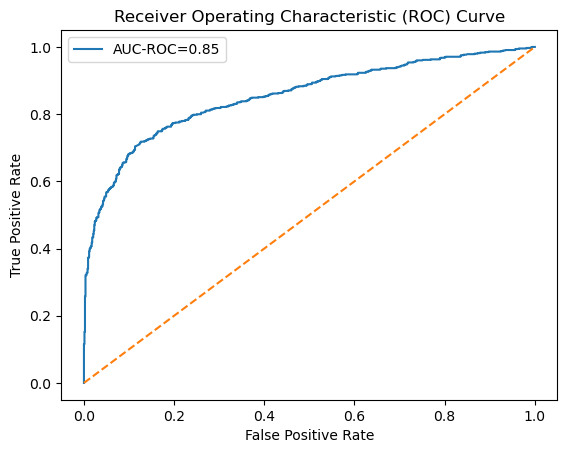

In [67]:
from sklearn.metrics import roc_auc_score, roc_curve

pred_test_prob = svm.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, pred_test_prob)
fpr, tpr, _ = roc_curve(y_test, pred_test_prob)

plt.plot(fpr, tpr, label=f'AUC-ROC={auc_roc:.2f}')
# roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
# sns.lineplot(x='fpr', y='tpr', data=roc_df, label=f'AUC-ROC={auc_roc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Predictions

In [68]:
predictions = svm.predict(test_data['text'].to_frame())

# Submission

In [69]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submission.csv", index=False)

# Other methods to improve: 
* BERT